In [1]:
from microstruktur.signal_models import dispersed_models, gaussian_models
from microstruktur.core import modeling_framework, acquisition_scheme
from microstruktur.utils import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Synthetic Experiment

In [2]:
from microstruktur.data import saved_acquisition_schemes, saved_data
scheme = saved_acquisition_schemes.wu_minn_hcp_acquisition_scheme()

synthetic_data_parallel = saved_data.synthetic_camino_data_parallel()
synthetic_data_dispersed = saved_data.synthetic_camino_data_dispersed()

## Get an intial guess for orientation using Dipy's DTI

In [3]:
from dipy.reconst import dti

gtab = acquisition_scheme.gtab_mipy2dipy(scheme)
tenmod = dti.TensorModel(gtab)
tenfit_parallel = tenmod.fit(synthetic_data_parallel.signal_attenuation)
tenfit_dispersed = tenmod.fit(synthetic_data_dispersed.signal_attenuation)

In [4]:
mu_parallel_cart = tenfit_parallel.directions.squeeze()
mu_dispersed_cart = tenfit_dispersed.directions.squeeze()

In [5]:
from microstruktur.utils.utils import cart2sphere
mu_parallel = utils.cart2mu(mu_parallel_cart)
mu_dispersed = utils.cart2mu(mu_dispersed_cart)

## Generate NODDI-Bingham model

In [6]:
ball = gaussian_models.G3Ball()
dispersed_stick = dispersed_models.SD2C1BinghamDispersedStick()

BAR_mod = modeling_framework.MultiCompartmentMicrostructureModel(
    acquisition_scheme=scheme,
    models=[dispersed_stick, ball],
)

# Fix parallel diffusivity and isotropic diffusivity
BAR_mod.optimized_parameters['SD2C1BinghamDispersedStick_1_lambda_par'] = False

## Fit NODDI to data

In [7]:
param_parallel_x0 = BAR_mod.parameter_initial_guess_to_parameter_vector(
    SD2C1BinghamDispersedStick_1_mu=mu_parallel,
    SD2C1BinghamDispersedStick_1_beta=0.,
    SD2C1BinghamDispersedStick_1_psi=0.,
    SD2C1BinghamDispersedStick_1_lambda_par=1.7e-9,
)
param_dispersed_x0 = BAR_mod.parameter_initial_guess_to_parameter_vector(
    SD2C1BinghamDispersedStick_1_mu=mu_dispersed,
    SD2C1BinghamDispersedStick_1_beta=0.,
    SD2C1BinghamDispersedStick_1_psi=0.,
    SD2C1BinghamDispersedStick_1_lambda_par=1.7e-9,
)

SD2C1BinghamDispersedStick_1_mu successfully set.
SD2C1BinghamDispersedStick_1_beta successfully set.
SD2C1BinghamDispersedStick_1_lambda_par successfully set.
SD2C1BinghamDispersedStick_1_psi successfully set.
SD2C1BinghamDispersedStick_1_mu successfully set.
SD2C1BinghamDispersedStick_1_beta successfully set.
SD2C1BinghamDispersedStick_1_lambda_par successfully set.
SD2C1BinghamDispersedStick_1_psi successfully set.


In [9]:
# fitting to parallel (undispersed) data varying diffusivity D=[1.7, 2.0, 2.3]
BAR_fit = BAR_mod.fit(
    synthetic_data_parallel.signal_attenuation,
    parameter_initial_guess=param_parallel_x0)

# fitting to dispersed data varying diffusivity D=[1.7, 2.0, 2.3]
BAR_fit_dispersed = BAR_mod.fit(
    synthetic_data_dispersed.signal_attenuation,
    parameter_initial_guess=param_dispersed_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 537.574642897 seconds.
Average of 0.181001563265 seconds per voxel.


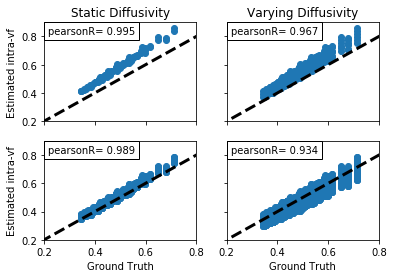

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

saved_data.visualize_correlation_camino_and_estimated_fractions(
    BAR_fit.fitted_parameters['partial_volume_0'].squeeze(),
    BAR_fit_dispersed.fitted_parameters['partial_volume_0'].squeeze())

# Human Connectome Project Example

In [12]:
from microstruktur.data import saved_data
data = saved_data.wu_minn_hcp_coronal_slice()

This data originates from Subject 100307 of the WU-Minn Human Connectome Project. View terms of use at https://store.humanconnectome.org/data/data-use-terms/open-access.php


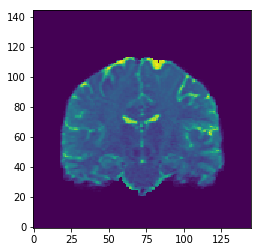

In [13]:
plt.imshow(data[:,0,:,0].T, origin=True)

## Get an intial guess for orientation using Dipy's DTI

In [14]:
tenmod = dti.TensorModel(gtab)
tenfit = tenmod.fit(data, mask=data[..., 0]>0)

In [15]:
mu_cart = tenfit.directions[..., 0, :]
mu = utils.cart2mu(mu_cart)

param_x0 = BAR_mod.parameter_initial_guess_to_parameter_vector(
    SD2C1BinghamDispersedStick_1_mu=mu,
    SD2C1BinghamDispersedStick_1_lambda_par=1.7e-9,
    SD2C1BinghamDispersedStick_1_beta=0.,
    SD2C1BinghamDispersedStick_1_psi=0.,
)
BAR_mod.optimized_parameters['SD2C1BinghamDispersedStick_1_lambda_par'] = False

SD2C1BinghamDispersedStick_1_mu successfully set.
SD2C1BinghamDispersedStick_1_beta successfully set.
SD2C1BinghamDispersedStick_1_lambda_par successfully set.
SD2C1BinghamDispersedStick_1_psi successfully set.


/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/utils/utils.py:338: RuntimeWarning: invalid value encountered in divide
  mu[..., 0] = np.arccos(xyz[..., 2] / r)  # theta


## Fit NODDI to HCP data

In [16]:
BAR_fit_hcp = BAR_mod.fit(
    data=data, mask=data[..., 0]>0,
    parameter_initial_guess=param_x0)

Using parallel processing with 8 workers.
Starting fitting process
Fitting complete in 1781.03187799 seconds.
Average of 0.217703444322 seconds per voxel.


## Visualize results

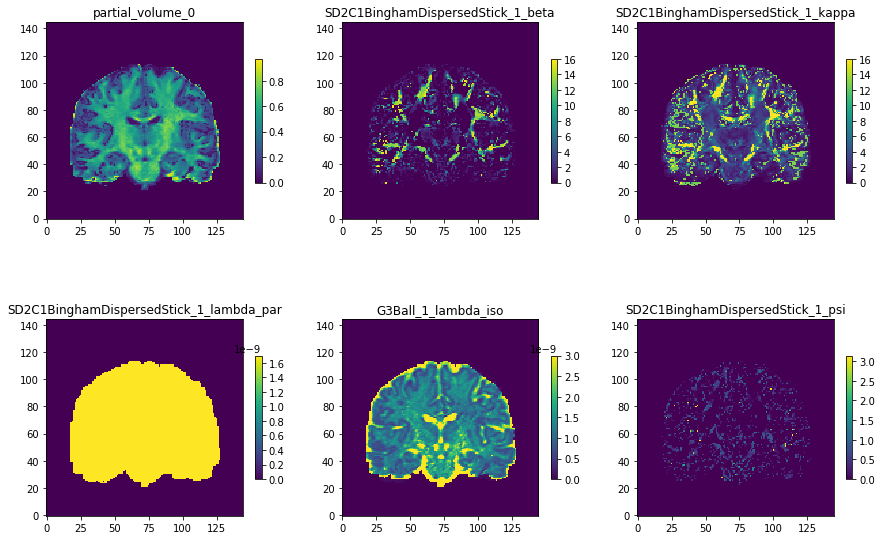

In [24]:
fitted_parameters = BAR_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 3, figsize=[15, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    fig.colorbar(cf, ax=axs[counter], shrink=0.5)
    counter += 1

Notice that we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment.

The more unfamiliar maps are those of $\beta$, $\kappa$ and $\psi$. $\kappa$ represents primary isotropic concentration as in NODDI, while $\beta$ describes the anisotropy of the concentration (bending or fanning tissue). $\psi$ describes the angle of the anisotropy.

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Estimating Fiber Orientation Distributions (FODs)

We estimate FODs on the right side of the corpus callosum and use the estimated concentration $\kappa$ as background.

In [18]:
from dipy.data import get_sphere
from dipy.viz.actor import slicer
sphere = get_sphere(name='symmetric724')
fods = BAR_fit_hcp.fod(sphere.vertices)

In [19]:
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

kappa_res = fitted_parameters['SD2C1BinghamDispersedStick_1_kappa']
kappa_res.shape
kappa_im = slicer(kappa_res[70:90,0, 70:90],interpolation='nearest', affine=affine, opacity=0.7)

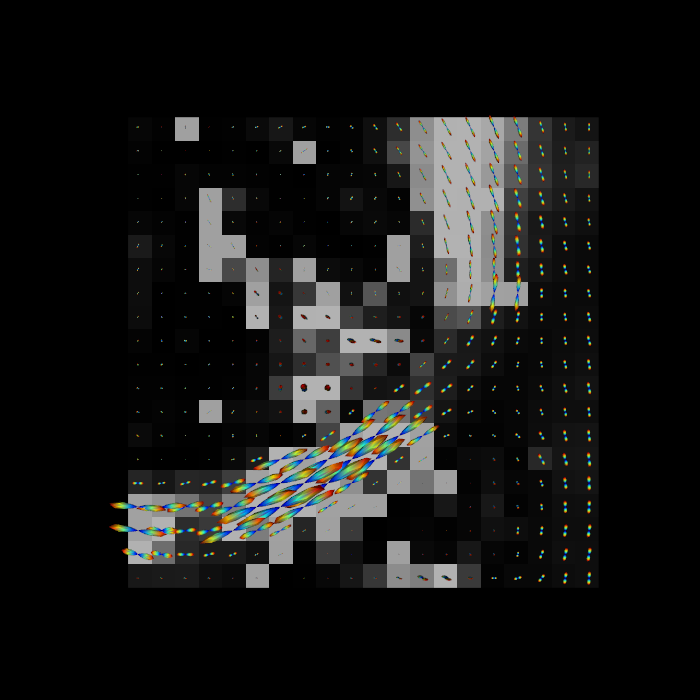

In [20]:
from dipy.viz import fvtk
ren = fvtk.ren()
fod_spheres = fvtk.sphere_funcs(fods[70:90,:, 70:90], sphere, scale=1., norm=False)
fod_spheres.RotateX(90)
fod_spheres.RotateZ(180)
fod_spheres.RotateY(180)
fvtk.add(ren, fod_spheres)
fvtk.add(ren, kappa_im)
fvtk.record(ren=ren, size=[700, 700])

from IPython.display import Image
Image(filename='dipy.png', width=700)

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows the concentration $\kappa$ of the Watson distribution. Notice it is high in the corpus callosum and lower in non-white matter areas. Also notice that in the CSF on the bottom you see very high $\kappa$, but it means nothing since the intra-axonal volume fraction close to zero in these areas. Also notice that Ball and Racket cannot estimate crossings, which are expected in the centrum semiovale on the right. Using multiple compartments to model crossings is explored in the Microstructure in Crossings examples.

In [21]:
from os import remove
remove('dipy.png')

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:899: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]
/user/rfick/home/anaconda2/lib/python2.7/site-packages/microstruktur-0.1.dev0-py2.7.egg/microstruktur/core/modeling_framework.py:880: RuntimeWarning: invalid value encountered in true_divide
  data_ = data / self.S0[..., None]


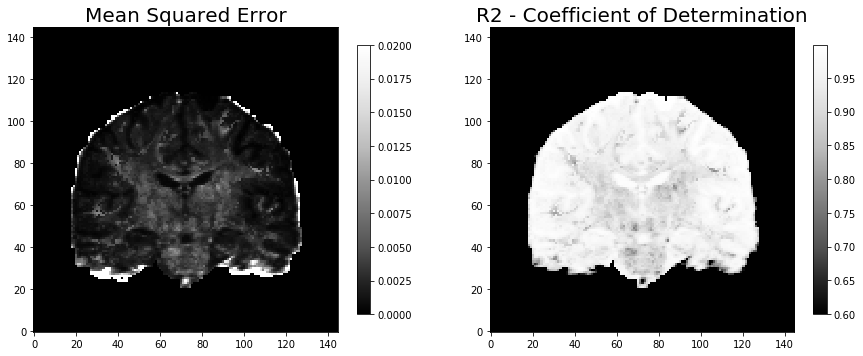

In [22]:
mse = BAR_fit_hcp.mean_squared_error(data)
R2 = BAR_fit_hcp.R2_coefficient_of_determination(data)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in Ball and Racket we can see clearly see the structure of the different brain areas. This means that Ball and Racket model cannot fit the diffusion equally well in all brian areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.